In [16]:
import numpy as np
import pandas as pd

df = pd.read_csv('/mnt/blossom/more/pbansal/dataset/nyc_taxi/yellow_tripdata_2019-01.csv')
lookup = pd.read_csv('/mnt/blossom/more/pbansal/dataset/nyc_taxi/taxi+_zone_lookup.csv')
zone_lookup = dict({})
borough_to_code = {"Brooklyn":0,"Manhattan":1,"Queens":2,"Bronx":3,"Unknown":4,"EWR":5,"Staten Island":6}
for x in lookup.iterrows():
    zone_lookup[x[1]['LocationID']] = borough_to_code[x[1]['Borough']]

In [17]:
data = df[['tpep_pickup_datetime','PULocationID','DOLocationID','passenger_count']]
data['discrete_time'] = 0
def foo(x):
    date_time = pd.to_datetime(x['tpep_pickup_datetime'])
    return (((date_time.year-2019)*12 + (date_time.month-1))*31 + (date_time.day-1))#*24 + date_time.hour
data['discrete_time'] = data.apply(lambda x : foo(x),axis=1)
# data['DOZone'] = data.apply(lambda x : zone_lookup[x['DOLocationID']],axis=1)
# data['PUZone'] = data.apply(lambda x : zone_lookup[x['PULocationID']],axis=1)

/mnt/a99/d0/pbansal/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/mnt/a99/d0/pbansal/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [18]:
data_19 = data.loc[data['discrete_time'] >= 0].loc[data['discrete_time'] <= 30][['discrete_time','PULocationID','DOLocationID','passenger_count']]
data_19 = data_19.groupby(["discrete_time","PULocationID","DOLocationID"],as_index=False).sum()

In [19]:
#data_19['DOZone'].unique()
#data_19['PULocationID'].unique().max()
data_19

,discrete_time,PULocationID,DOLocationID,passenger_count
0,0,1,1,39
1,0,1,132,3
2,0,3,3,2
3,0,3,51,2
4,0,3,61,1
...,...,...,...,...
324276,30,265,239,1
324277,30,265,257,1
324278,30,265,262,1
324279,30,265,264,2


In [20]:
out_array = np.zeros((31,266,266)).astype(np.float)
for x in data_19.iterrows():
    out_array[int(x[1]['discrete_time'])][int(x[1]['PULocationID'])][int(x[1]['DOLocationID'])] = x[1]['passenger_count']

In [25]:
print (np.median(out_array,axis=0)[None,:,:])

[[[0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
  [0.000e+00 2.200e+01 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
  [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
  ...
  [0.000e+00 3.000e+00 0.000e+00 ... 5.570e+02 7.000e+00 1.000e+00]
  [0.000e+00 5.000e+00 0.000e+00 ... 1.300e+01 6.296e+03 1.900e+01]
  [0.000e+00 2.000e+00 0.000e+00 ... 0.000e+00 1.000e+00 1.240e+02]]]


In [23]:
out_array_sub = out_array - np.median(out_array,axis=0)[None,:,:]
row_sums = np.sqrt(np.maximum(np.multiply(out_array_sub,out_array_sub),1e-20).sum(axis=0)[None,:,:]/out_array.shape[0])
norm_out_array = out_array_sub / row_sums
norm_out_array.shape
np.save('dataset/nyc_taxi_norm_meadian_numpy_complete',norm_out_array)
# norm_out_array[20] += 5
# np.save('dataset/nyc_taxi_norm_meadian_numpy_20_modified',norm_out_array)

#np.save('dataset/nyc_taxi_norm_meadian_numpy_train',norm_out_array[:700])
#np.save('dataset/nyc_taxi_norm_meadian_numpy_test_7months',norm_out_array[27:])
#np.save('dataset/nyc_taxi_norm_meadian_numpy_test_5months',norm_out_array[29:])
#np.save('dataset/nyc_taxi_norm_meadian_numpy_test_3months',norm_out_array[29:32])
#np.save('dataset/nyc_taxi_norm_meadian_numpy_test_1months',norm_out_array[31:32])
#np.save('dataset/nyc_taxi_norm_meadian_numpy_test_last_2months',norm_out_array[32:])
#np.save('dataset/nyc_taxi_norm_meadian_numpy_test',norm_out_array[700:])

In [22]:
data_19

,discrete_time,PULocationID,DOLocationID,passenger_count
0,0,1,1,39
1,0,1,132,3
2,0,3,3,2
3,0,3,51,2
4,0,3,61,1
...,...,...,...,...
324276,30,265,239,1
324277,30,265,257,1
324278,30,265,262,1
324279,30,265,264,2


In [24]:
f = open('dataset/nyc_taxi_norm_median_csv_complete.csv','w')
f.write('time,PUZone,DOZone,Measure\n')
for i in range(norm_out_array.shape[0]):
    for j in range(norm_out_array.shape[1]):    
        for k in range(norm_out_array.shape[2]):
            f.write('%d,%d,%d,%f\n'%(i,j,k,norm_out_array[i][j][k]))

In [35]:
num_points = int(27*266*266)
all_examples = np.zeros((num_points,3))
id_ = 0
for i in range(2,29):
    for j in range(266):
        for k in range(266):
            all_examples[id_,0] = i
            all_examples[id_,1] = j
            all_examples[id_,2] = k
            id_ += 1
np.random.shuffle(all_examples)
test_size = int(all_examples.shape[0]/3)
np.save('dataset/nyc_taxi_test_examples.npy',all_examples[:test_size])
np.save('dataset/nyc_taxi_train_examples.npy',all_examples[test_size:])
#outliers_ = np.concatenate((np.random.randint(2,5,(num_points,1)),np.random.randint(0,60,(num_points,1)),np.random.randint(0,84,(num_points,1))),1)

In [36]:
num_points = int(26*266*266)
no20_examples = np.zeros((num_points,3))
id_ = 0
for i in range(2,28):
    for j in range(266):
        for k in range(266):
            if (i >= 20):
                no20_examples[id_,0] = i+1
            else : 
                no20_examples[id_,0] = i                
            no20_examples[id_,1] = j
            no20_examples[id_,2] = k
            id_ += 1
            
num_points = int(1*266*266)
all_20_examples = np.zeros((num_points,3))
id_ = 0
for i in range(20,21):
    for j in range(266):
        for k in range(266):
            all_20_examples[id_,0] = i                
            all_20_examples[id_,1] = j
            all_20_examples[id_,2] = k
            id_ += 1
np.random.shuffle(all_20_examples)
np.random.shuffle(no20_examples)
#test_size = int(no20_examples.shape[0]/3)
np.save('dataset/nyc_taxi_test_all_20_examples.npy',all_20_examples)
np.save('dataset/nyc_taxi_train_all_no20_examples.npy',no20_examples)

In [65]:
non_zero_non_20_examples = data_19[["discrete_time","PULocationID","DOLocationID"]].loc[data_19['discrete_time'] > 1].loc[data_19['discrete_time'] != 20].loc[data_19['discrete_time'] < 29].to_numpy()
non_zero_20_examples = data_19[["discrete_time","PULocationID","DOLocationID"]].loc[data_19['discrete_time'] == 20].to_numpy()
np.random.shuffle(non_zero_non_20_examples)
np.random.shuffle(non_zero_20_examples)
np.save('dataset/nyc_taxi_test_non_zero_20_examples.npy',non_zero_20_examples)
np.save('dataset/nyc_taxi_train_non_zero_no20_examples.npy',non_zero_non_20_examples)

In [64]:
non_zero_20_examples

array([[ 20, 136, 153],
       [ 20, 138,  12],
       [ 20,  48, 116],
       ...,
       [ 20, 138, 157],
       [ 20, 114,  67],
       [ 20,  13, 181]])

In [1]:
import csv
import torch
import pandas as pd
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

In [70]:
######### Generate outlier validation set ##################
test_set = np.load('dataset/nyc_taxi_norm_meadian_numpy_test.npy')
#print (test_set.shape)
num_points = 1000
#45,266,7
outliers_ = np.concatenate((np.random.randint(2,43,(num_points,1)),np.random.randint(0,266,(num_points,1)),np.random.randint(0,7,(num_points,1))),1)
for x in outliers_ :
    test_set[x[0],x[1],x[2]] += 3
np.save('dataset/nyc_taxi_norm_meadian_numpy_test_modified_our.npy',test_set)
np.save('dataset/nyc_taxi_norm_meadian_numpy_test_modified_org_rvae.npy',test_set[2:43])
outliers_ = np.unique(outliers_,axis=0)
print (outliers_.shape)
outliers_ = outliers_.tolist()
# plt.scatter(test_set[1],np.zeros(test_set[1].shape))
# np.where(test_set[1]>5.5)

(995, 3)


In [13]:
from helper import NN, Dataset_
device = torch.device('cuda:0')
loss = torch.nn.L1Loss()
batch_size = 128
#test_set = Dataset_('dataset/nyc_taxi_norm_meadian_numpy_20_modified.npy','dataset/nyc_taxi_test_all_20_examples.npy')
#test_set = Dataset_('dataset/nyc_taxi_norm_meadian_numpy_complete.npy','dataset/nyc_taxi_test_examples.npy')
test_set = Dataset_('dataset/nyc_taxi_norm_meadian_numpy_20_modified.npy','dataset/nyc_taxi_test_non_zero_20_examples.npy')

test_loader = torch.utils.data.DataLoader(test_set,batch_size = batch_size,drop_last = True)
model = NN().to(device)
epoch = 60
model.load_state_dict(torch.load('/mnt/blossom/more/pbansal/nyc_checkpoints/checkpoint_%d'%epoch))
pred_ = []
loss_ = 0
for x,y,index in test_loader :
    with torch.no_grad():
        x = x.to(device)
        y_pred = model(x)
        y = y.to(device)
        loss_ += loss(y,y_pred).data
        for i in range(batch_size):
            y_ = y[i].data.cpu().numpy() 
            pre_ = y_pred[i].data.cpu().numpy()
            pred_.append([y_,pre_])
#             if (abs(y_-pre_)>3):
#                 outliers.append(((index[0][i],index[1][i],index[2][i]),(y_,pre_)))
# loss_ = (loss_/int(len(test_set)/batch_size)).cpu().data.numpy()
# print (loss_)
pred_ = np.array(pred_)

loading dataset


In [3]:
from ConditionalPredictor.helper import Dataset_,NN

import os

batch_size = 64
pred_cond_pred = []
def test_ ():
    #val_set = Dataset_('dataset/nyc_taxi_norm_meadian_numpy_20_modified.npy','dataset/nyc_taxi_test_all_20_examples.npy')
    #val_set = Dataset_('dataset/nyc_taxi_norm_meadian_numpy_complete.npy','dataset/nyc_taxi_test_examples.npy')
    val_set = Dataset_('dataset/nyc_taxi_norm_meadian_numpy_20_modified.npy','dataset/nyc_taxi_test_non_zero_20_examples.npy')
    
    val_loader = torch.utils.data.DataLoader(val_set,shuffle=True,batch_size = batch_size,drop_last=True)
    model = NN().cuda()
    loss = torch.nn.L1Loss()
    epoch = 25
    model.load_state_dict(torch.load(os.path.join('/mnt/blossom/more/pbansal/nyc_checkpoints_cond_pred/','checkpoint_%d'%epoch)))
    loss_ = 0
    for x,y,_ in val_loader :
        with torch.no_grad():
            x = x.cuda()
            y_pred = model(x)
            y = y.cuda()
            loss_ += loss(y,y_pred).data
            for i in range(batch_size):
                y_ = y[i].data.cpu().numpy() 
                pre_ = y_pred[i].data.cpu().numpy()
                pred_cond_pred.append([y_,pre_])
    loss_ = loss_/int(len(val_set)/batch_size)
    return loss_
print (test_())
pred_cond_pred = np.array(pred_cond_pred)

loading dataset
tensor(4.8294, device='cuda:0')


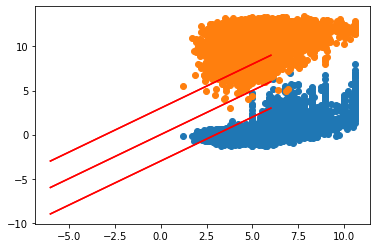

In [14]:
def plot(pred_):
    plt.scatter(pred_[:,0],pred_[:,1])
    plt.plot([-6,6],[-6,6],c='r')
    plt.plot([-6,6],[-3,9],c='r')
    plt.plot([-6,6],[-9,3],c='r')
plot(pred_cond_pred[:,:])
plot(pred_[:,:])